## Machine Translation using Seq2Seq Model - Freanch to English

Transformer is popular SOTA (state-of-the-art) architecture and used in today's a lot of successful works in neural methods.<br>
Finally we'll implement transformer using previously learned architectures - such as, language modeling, encoder-decoder, and attention.

As we saw in Attention Model, attention captures the distant relationship and contexts in sequences.<br>
Transformer is motivated by this successful architecture.

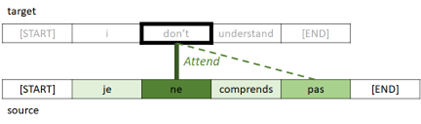<br>
*From : "08 Attention (Machine Translation Example)"*

In this example, we will implement the architecture written in the famous paper "[Attention Is All You Need](https://arxiv.org/abs/1706.03762)".<br>
As you saw in [exercise 08](./08_attention.ipynb), we have used RNN architecture (GRU gate) for getting contexts in encoder and decoder. However, in this transformer architecture, attention is also used even for getting contexts in encoder and decoder, instead of using RNN architecture. (In below architecture, you will find that there's no RNN layers.)<br>
Total 3 attend layers (encoder's self-attention, decoder's self-attention, and encoder-decoder cross attention) are then applied in this network.

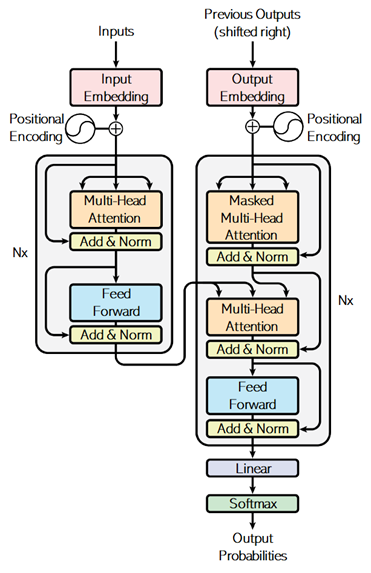<br>
*From : "[Attention Is All You Need](https://arxiv.org/abs/1706.03762)" (Vaswani, et al., 2017)*

Unlike soft attention in [exercise 08](./08_attention.ipynb), it applies the following attention - which is called "**scaled dot-product attention**" - in these 3 parts of attend layers.<br>
As you can see below, this model measures the similarity by the dot-product operation, and 3 networks for composing query, key, and value will be trained. When the query vector and key vector are similar, it will have a large value of dot product between these vectors. Such like soft attention (in [exercise 08](./08_attention.ipynb)), the matrix $Q \cdot K^T$ will then have the relationship mapping (weight's mapping) between query and key. Finally, by applying dot-product operation again between this result and value's vector, the final feature vectors will be obtained in each token.<br>
To say intuitively, first dot-product operation asks each keys by queries in the sequence, and then composes the objectives by combining between its results and values by the second dot-product operation.

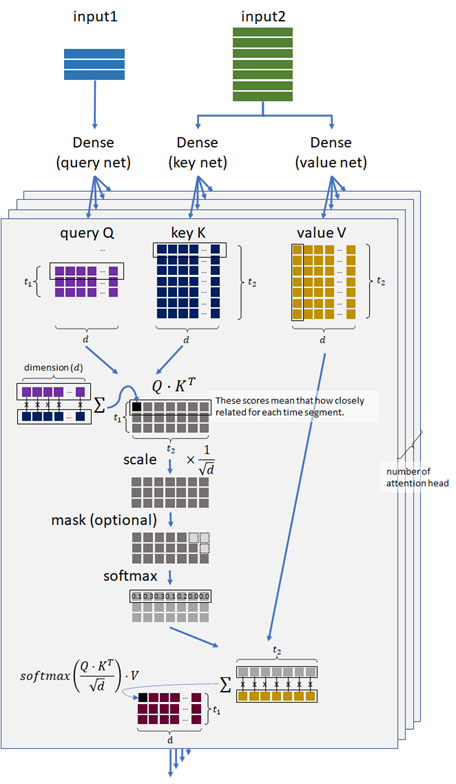

In the attend layer in encoding and decoding (see below), input1 and input2 are the same sequence in above scaled dot-product attention. This architecture is called **self-attention**.<br>
For instance, the word "this" in "this is a pen" will have the close relationship with the word "pen". The self-attention captures this kind of self-regressive relations in the sequence.<br>
By capturing these relations, the sequence will be well annotated in both encoder and decoder, instead of using RNN layer.

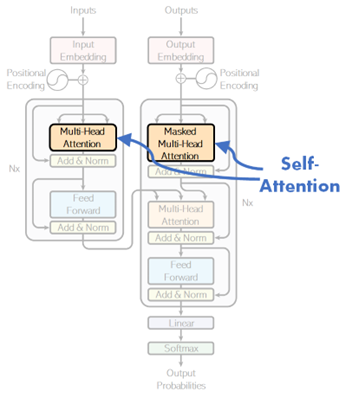

> Note : On contrary, the above cross-attention layer is for machine translation task.

> Note : In the self-attention layer in decoder, each time segment should not refer to the future segment. It then applies the masked attention, instead of applying fully-connected attention.<br>
> Later I'll explain about this causal attention.

By the design of this architecture, transformers will have the ability to capture the distant contexts and we can also expect to have the ability to capture more difficult contexts rather than RNN-based encoder-decoder.

As I have mentioned above, transformer is today's key part for SOTA (state-of-the-art) language models and a lot of today's famous algorithms (such as, BERT, T5, GPT, etc) use transformers in its architectures.<br>
As you saw in [basic language model's example](./05_language_model_basic.ipynb), we can train transformers with unsupervised approach - such as, next word's prediction, masked word's prediction. By this unsupervised fashion, a lot of today's algorithms learn a lot of language properties with existing large corpus (such as, Wikipedia), and can then be fine-tuned for downstream tasks with small number of labeled data - such as, sentiment detection, text classification, summarization, or modern instruction fine-tuning, etc. (See [here](https://tsmatz.wordpress.com/2022/10/24/huggingface-japanese-ner-named-entity-recognition/) for fine-tuning example in Hugging Face.)

> Note : Transformers are categorized into 3 types : encoder-only, decoder-only, and encoder-decoder.<br>
> For instance, you can use only encoder's architecture and apply classification for named entity recognitions. You may also use text encoding for image generation.<br>
> A lot of today's popular large language models (LLMs) - such as, ChatGPT, LLaMA, Bard, etc - are decoder-only models. These are in-context generative models, in which the output is generated by using the context of inputs (prompt), and the input's text (prompting) is then very important to get the optimal results in these models.<br>
> See [here](https://arxiv.org/abs/2304.13712) for the summary of encoder-only, decoder-only, and encoder-decoder language models.

Now let's see the implementation of each part in this transofrmer architecture, and train the model for machine translation task.<br>
For your learning purpose, I'll implement all layers (modules) from scratch, but you can also use built-in ```torch.nn.MultiheadAttention``` in PyTorch.

*back to [index](https://github.com/tsmatz/nlp-tutorials/)*

In [1]:
# !pip install torch==1.13.1 torchtext==0.14.1
# !pip install numpy nltk
# !wget http://www.manythings.org/anki/fra-eng.zip
# !unzip fra-eng.zip -d fra-eng

### Dataset Preparation
Engligh-French dataset by [Anki] https://www.manythings.org/anki/

In [2]:
!head -n 5 fra-eng/fra.txt

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Go.	Marche.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)
Go.	En route !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)
Go.	Bouge !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)


In [3]:
!wc -l fra-eng/fra.txt

227815 fra-eng/fra.txt


In [4]:
from pathlib import Path
import numpy as np

import nltk
import nltk.data

import string

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch
from torch.utils.data import DataLoader

import torch.nn as nn

In [5]:
np.random.seed(42)
torch.manual_seed(42)

In [6]:
pathobj = Path("fra-eng/fra.txt")
text_all = pathobj.read_text(encoding="utf-8")
lines = text_all.splitlines()
print(f'No. of lines in the file: {len(lines)}')

No. of lines in the file: 227815


In [7]:
train_data_raw = [line.split("\t") for line in lines]
# only select column 1 and 0 in the order.
# IMP: Keeping in this order will make Frn column then Eng column.
train_data_raw = np.array(train_data_raw)[:,[1,0]]
# print first row
train_data_raw[0]

array(['Va !', 'Go.'], dtype='<U349')

## Note:
- Whole data is considered a training data
- The text length in the dataset is longer (and includes multiple sentences) in later part. Shuffle entire data.

In [8]:
np.random.shuffle(train_data_raw)
train_data_raw[0]

array(['Je voulais simplement te rendre heureuse.',
       'I just wanted to make you happy.'], dtype='<U349')

In [9]:
# Punkt tokenizer is alreay downloaded previously
tokenizer_en = nltk.data.load("tokenizers/punkt/english.pickle")
tokenizer_fr = nltk.data.load("tokenizers/punkt/french.pickle")
fr_list = []
en_list = []

In [10]:
for x in train_data_raw:
    x1 = tokenizer_fr.tokenize(x[0])
    x2 = tokenizer_en.tokenize(x[1])
    # don't use data if it consists of multiple sentences.
    # Eng --> No. of sentence == Frn --> No. of sentence
    if len(x1) == len(x2):
        fr_list += x1
        en_list += x2
    #Debug code
    #    break

In [11]:
train_data = np.column_stack((fr_list, en_list))

In [12]:
print(f'0th: {train_data[0]}')
print(f'1st: {train_data[1]}')

0th: ['Je voulais simplement te rendre heureuse.'
 'I just wanted to make you happy.']
1st: ['Nous ne pouvons être les deux seules personnes à être en retard.'
 "We can't be the only two people who're late."]


In [13]:
train_data = np.char.lower(train_data)
train_data = np.char.replace(train_data, "-", " ")
# Remove all punctuation except " ' " (e.g, don't)
#     1. Get punctutaion present in string.punctuation
#     2. Remove "'" from string.punctuation string.
for x in string.punctuation.replace("'", ""):
    train_data = np.char.replace(train_data, x, "")

In [14]:
train_data[0]

array(['je voulais simplement te rendre heureuse',
       'i just wanted to make you happy'], dtype='<U250')

In [15]:
# There are some sentence having << & >>. Remove them as well.
for x in "«»":
    train_data = np.char.replace(train_data, x, "")
train_data = np.char.strip(train_data)

In [16]:
# Add <start> and <end> tokens in string.
train_data = np.array([[" ".join(["<start>", x, "<end>"]), " ".join(["<start>", y, "<end>"])] for x, y in train_data])
train_data[0]

array(['<start> je voulais simplement te rendre heureuse <end>',
       '<start> i just wanted to make you happy <end>'], dtype='<U264')

#### Generate sequence inputs
Note: max_word = 10000
- Generate vocab for both Eng & Frn
- Generate the sequence of word's indices (i.e, tokenize) from text.
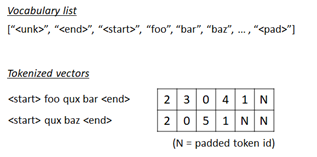

In [17]:
max_word = 10000

# create space-split tokenizer
tokenizer = get_tokenizer(None)

# define tokenization function
def yield_tokens(data):
    for text in data:
        tokens = tokenizer(text)
        yield tokens


In [18]:
# build vocabulary list for French
vocab_fr = build_vocab_from_iterator(
    yield_tokens(train_data[:,0]),
    specials=["<unk>"],
    max_tokens=max_word
)
vocab_fr.set_default_index(vocab_fr["<unk>"])


In [19]:
# build vocabulary list for English
vocab_en = build_vocab_from_iterator(
    yield_tokens(train_data[:,1]),
    specials=["<unk>"],
    max_tokens=max_word
)
vocab_en.set_default_index(vocab_en["<unk>"])

In [20]:
print(f'Frn Vocab size: {vocab_fr.__len__()}')

Frn Vocab size: 10000


In [21]:
print(f'Eng Vocab size: {vocab_en.__len__()}')

Eng Vocab size: 10000


In [22]:
# The generated token index is 0, 1, ... , vocab_size - 1.
# Set vocab_size as a token id in padded positions for both French and English respctively.
pad_index_fr = vocab_fr.__len__()
vocab_fr.append_token("<pad>")

pad_index_en = vocab_en.__len__()
vocab_en.append_token("<pad>")

In [23]:
pad_index_fr

10000

In [24]:
pad_index_en

10000

In [25]:
# Get list for index-to-word / word-to-index.
itos_fr = vocab_fr.get_itos()
stoi_fr = vocab_fr.get_stoi()

itos_en = vocab_en.get_itos()
stoi_en = vocab_en.get_stoi()

In [26]:
itos_fr[5]

'pas'

In [27]:
print("# of token index in French (source) is {}.".format(vocab_fr.__len__()))
print("The padded index in French (source) is {}.".format(stoi_fr["<pad>"]))
print("=============================================")
print("# of token index in English (target) is {}.".format(vocab_en.__len__()))
print("The padded index in English (target) is {}.".format(stoi_en["<pad>"]))

# of token index in French (source) is 10001.
The padded index in French (source) is 10000.
# of token index in English (target) is 10001.
The padded index in English (target) is 10000.


In [28]:
train_data[22824]

array(['<start> tom est arrivé en avance <end>',
       '<start> tom came early <end>'], dtype='<U264')

In [29]:
# test
test_fr_text = "<start> est ce que tu sais pourquoi <end>"
vocab_fr(tokenizer(test_fr_text))

[2, 16, 15, 6, 12, 58, 66, 1]

In [30]:
# test
test_en_text = "<start> do you know why <end>"
vocab_en(tokenizer(test_en_text))

[2, 11, 4, 30, 62, 1]

#### collator function that  is used for pre-processing in data loader.

`Important:`
- During training, the decoder predicts the next word in target (English) sequence using the current word's sequence (English) and the encoded context of source (French).
- Hence, for target (English) sequence, we separate into features (x) and labels (y). In another words, separate target sequence into the sequence iteself (x) and the following label (y).

Ex:
actual eng token: `[2, 11, 4, 30, 62, 1]`

After above mentioned step:

x : `[2, 11, 4, 30, 62, 1]`
y : `[11, 4, 30, 62, 1, -100]`

Note : Here we set -100 as an unknown label id, because PyTorch cross-entropy function (`torch.nn.functional.cross_entropy())` has a property ignore_index which default value is -100.

In [31]:
batch_size=64
seq_len_fr = 45
seq_len_en = 38

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, feature_source_list, feature_target_list = [], [], []
    for text_fr, text_en in batch:
        # (1) tokenize to a list of word's indices
        tokens_fr = vocab_fr(tokenizer(text_fr))
        tokens_en = vocab_en(tokenizer(text_en))
        # (2) separate into features and labels in target tokens (English)
        y = tokens_en[1:]
        y.append(-100)
        # (3) limit length to seq_len
        y = y[:seq_len_en]
        tokens_fr = tokens_fr[:seq_len_fr]
        tokens_en = tokens_en[:seq_len_en]
        # (4) pad sequence
        y += [-100] * (seq_len_en - len(y))
        tokens_fr += [pad_index_fr] * (seq_len_fr - len(tokens_fr))
        tokens_en += [pad_index_en] * (seq_len_en - len(tokens_en))
        # add to list
        label_list.append(y)
        feature_source_list.append(tokens_fr)
        feature_target_list.append(tokens_en)
    # convert to tensor
    label_list = torch.tensor(label_list, dtype=torch.int64).to(device)
    feature_source_list = torch.tensor(feature_source_list, dtype=torch.int64).to(device)
    feature_target_list = torch.tensor(feature_target_list, dtype=torch.int64).to(device)
    return label_list, feature_source_list, feature_target_list

# train_data: ['French sentence', 'English sentence']
dataloader = DataLoader(
    list(zip(train_data[:,0], train_data[:,1])),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

In [32]:
train_data[:,0]

array(['<start> je voulais simplement te rendre heureuse <end>',
       '<start> nous ne pouvons être les deux seules personnes à être en retard <end>',
       '<start> je sais que tom était malade <end>', ...,
       '<start> voulez vous un petit déjeuner <end>',
       '<start> nous travaillons aussi vite que nous le pouvons <end>',
       "<start> ça a l'air plutôt cher <end>"], dtype='<U264')

In [33]:
# test code: Notice the 'break'
for labels, sources, targets in dataloader:
    break

print("label shape in a batch : {}".format(labels.size()))
print("feature source/Frn shape in a batch : {}".format(sources.size()))
print("feature target/Eng shape in a batch : {}".format(targets.size()))
print("\n***** label sample *****")
print(labels[0])
print("\n***** features (source) sample *****")
print(sources[0])
print("\n***** features (target) sample *****")
print(targets[0])

label shape in a batch : torch.Size([64, 38])
feature source/Frn shape in a batch : torch.Size([64, 45])
feature target/Eng shape in a batch : torch.Size([64, 38])

***** label sample *****
tensor([  41,   39,    4,   33,    6,  412,    1, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100])

***** features (source) sample *****
tensor([    2,    78,    16,    15,     6,    12,    53,   288,    10,   428,
            1, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000])

***** features (target) sample *****
tensor([    2,    41,    39,     4,    33,     6,   412,     1, 10000, 10000,
        10000, 10000, 10000, 10000, 100

### Positional Encoding
In the formal algorithms of transformer, the set of embedded tokens are encoded by positions without any additional parameters.
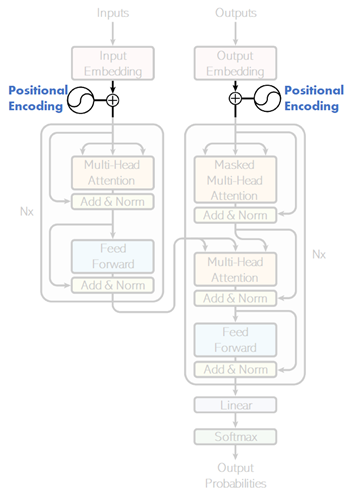


If there's no positional encoding, the sequence will be treated as a bag of tokens in neural networks. The positional information is needed for position-aware processing in attention.

There exist several ways (variations) for positional encoding.<br>
In this example, I'll apply the following positional encoding method (called **sinusoidal positional encoding**), which is introduced in the [original paper](https://arxiv.org/abs/1706.03762) of transformer.

For `max_word=10000` <br><br>
(1) The positional vector $PE(t)$ is :<br>
$ PE(t,2i) = \sin(t / 10000^{2i / d_e}) $<br>
$ PE(t,2i+1) = \cos(t / 10000^{2i / d_e}) $<br>
for $0 \leq i \lt d_e / 2$<br>
where $t = \{0, 1, \ldots\}$ is position (time-step) and $d_e$ is embedding dimemsion.

(2) For $t$-th token in the sequence, the embedding $E(t) \in \mathbb{R}^{d_e}$ then becomes $ E(t) + PE(t) $.

> Note : Here I assume that $d_e$ (embedding dimension) is an even number. (When it's an odd number, the dimension between $E(t)$ and $PE(t)$ differs.)

By applying this positional encoding, we can expect that the attention network will easily learn the position in each tokens, since there always exist a $ 2 \times 2 $ matrix $\mathbf{M}_{ik}$ (depending on $i$ and $k$) which satisfies

$$ \begin{pmatrix} PE(t+k,2i)\\PE(t+k,2i+1) \end{pmatrix} = \mathbf{M}_{ik} \begin{pmatrix} PE(t,2i)\\PE(t,2i+1) \end{pmatrix} $$

for any $t$.

> Note : In GPT, positional encoding is not a fixed encoding (not like above sinusoidal positional encoding) and it's also learned in the training.

In [34]:
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, embedding_dim):
        assert(embedding_dim % 2 == 0)

        super().__init__()

        # 1 / 10000^{2i / d_e}
        #   --> (embedding_dim / 2, )
        interval = 1.0 / (10000**(torch.arange(0, embedding_dim, 2.0) / embedding_dim))
        # t
        #   --> (seq_len, )
        position = torch.arange(0, seq_len).float()
        # t / 10000^{2i / d_e}
        #   --> (seq_len, embedding_dim / 2)
        radian = position[:, None] * interval[None, :]
        # sin(t / 10000^{2i / d_e})
        #   --> (seq_len, embedding_dim / 2, 1)
        sin = torch.sin(radian).unsqueeze(dim=-1)
        # cos(t / 10000^{2i / d_e})
        #   --> (seq_len, embedding_dim / 2, 1)
        cos = torch.cos(radian).unsqueeze(dim=-1)
        # PE
        #   --> (seq_len, embedding_dim / 2, 2)
        pe_tmp = torch.concat((sin, cos), dim=-1)
        # reshape
        #   --> (seq_len, embedding_dim)
        d = pe_tmp.size()[1]
        self.pe = pe_tmp.view(-1, d * 2).to(device)

    def forward(self, inputs):
        return inputs + self.pe

Now let's test the output of positional encoding layer that we created just above.<br>
In the following example, positional vectors will become :

```
[
  [sin(0), cos(0), sin(0/100), cos(0/100)],
  [sin(1), cos(1), sin(1/100), cos(1/100)],
  [sin(2), cos(2), sin(2/100), cos(2/100)],
]
```

In [39]:
test = PositionalEncoding(seq_len=3, embedding_dim=4).to(device)
print("##### positional vector #####")
print(test.pe)
# The input size should be (batch_size, seq_len, embedding_dim): (2, 3, 4)
x = torch.arange(1, 25).float()
x = x.view(2, 3, 4).to(device)
print("##### input vector #####")
print(x)
y = test(x)
print("##### positional Enconding output #####")
print(y)

##### positional vector #####
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998]])
##### input vector #####
tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.]],

        [[13., 14., 15., 16.],
         [17., 18., 19., 20.],
         [21., 22., 23., 24.]]])
##### positional Enconding output #####
tensor([[[ 1.0000,  3.0000,  3.0000,  5.0000],
         [ 5.8415,  6.5403,  7.0100,  9.0000],
         [ 9.9093,  9.5839, 11.0200, 12.9998]],

        [[13.0000, 15.0000, 15.0000, 17.0000],
         [17.8415, 18.5403, 19.0100, 21.0000],
         [21.9093, 21.5839, 23.0200, 24.9998]]])


<hr>

#  Multi-head and Scaled Dot-Product Attention

Next We will implement attention layer as follows.<br>
For the purpose of learning, we will implement the scaled dot-product attention layer from scratch.

> Note : In PyTorch, we can use built-in ```torch.nn.MultiheadAttention```.

In 3 parts of attention (encoder's self-attention, decoder's self-attention, and encoder-decoder cross attention), it runs the following steps. (See above description for the semantics of this model.) :

(1) The embedded inputs in the sequence are processed by dense networks (fully-connected feed-forward networks), and "query" ($Q$), "key" ($K$), and "value" ($V$) are then generated.

(2) Compute the relationship score between $Q$ and $K$ by the dot product, $Q \cdot K^T$.

(3) Scale the score by multiplying $\frac{1}{\sqrt{d}}$, where $d$ is the number of attention dimension.

(4) In decoder side, apply causal mask.<br>
Later we will see details about this optional causal mask ...

(5) The relationship between $Q$ and $K$ are softmaxed, i.e, normalized by $\displaystyle \frac{e^{s_i}}{e^{s_0} + e^{s_1} + \cdots + e^{s_{t-1}}}$ where $(s_0, s_1, \ldots , s_{t-1})$ is the relationship vector and $t$ is time-step.<br>
Pls note that the above scaling by $\frac{1}{\sqrt{d}}$ works as a softmax temprature in this step.

(6) Finally the result (softmaxed score) is performed by the dot product with $V$.<br>
The final result is then $\displaystyle \verb|softmax| \left( \frac{Q \cdot K^T}{\sqrt{d}} \right) \cdot V$.

As mentioned above, input1 and input2 in the following picture will be the same in ecoder's and decoder's self-attention parts.<br>

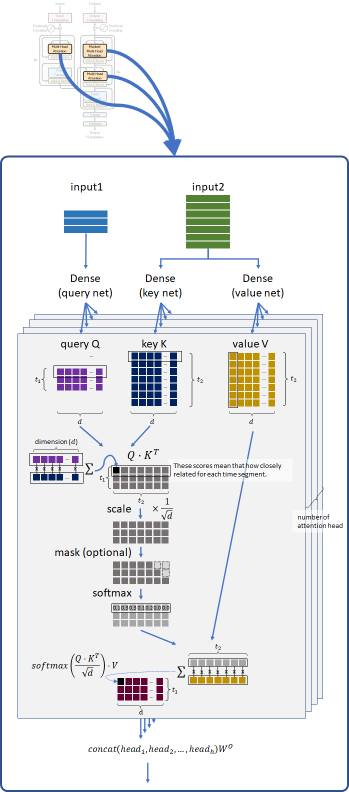

To make multiple attention work in parallel, model dimension (here 256) is divided into multiple heads (here 8), and each head will then have ```model_dim / head_num``` dimension (here 32). Finally, these separated heads are concatenated and then applied dense network to obtain model dimension's result. (See above picture.)<br>
This technique will make our model have rich expression without losing the computing costs.

Now it's time to explain about causal mask.<br>
In self-attention on decoder's side (when ```use_causal_mask=True``` in the following code), each token only refers past tokens and cannot access to the future tokens. (See the following picture.)

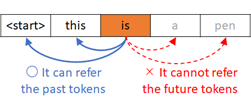

For this reason, the softmax operation in decoder's self-attention is performed only on lower triangular matrix as follows.<br>
This is because we apply optional mask before softmax operation.

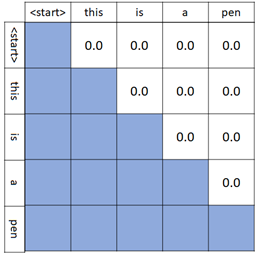

> Note : To make a lower triangular matrix, here I use ```torch.tril()``` in PyTorch.

In [40]:
import torch.nn as nn
from torch.nn import functional as F

class MyMultiHeadAttention(nn.Module):
    """Initializes a MyMultiHeadAttention module.

    Args:
        embedding_dim (int): The number of embedding dimensiom
        attention_dim (int): The number of dimension within attention unit
        num_heads (int): The number of the divided heads (See above.)
        use_causal_mask (bool): Whether to mask the future tokens (See above.)
    """
    def __init__(
        self,
        embedding_dim,
        attention_dim,
        num_heads,
        use_causal_mask=False):

        assert(attention_dim % num_heads == 0)

        super().__init__()

        self.num_heads = num_heads
        self.attention_dim = attention_dim
        self.head_dim = int(attention_dim / num_heads)
        self.use_causal_mask = use_causal_mask

        self.q_layer = nn.Linear(embedding_dim, attention_dim)
        self.k_layer = nn.Linear(embedding_dim, attention_dim)
        self.v_layer = nn.Linear(embedding_dim, attention_dim)
        self.output_linear = nn.Linear(attention_dim, attention_dim, bias=False)

    """
    When self-attention, input2 will be None
    """
    def forward(self, input1, mask1, input2=None, mask2=None):
        if input2 is None:
            input2 = input1
        if mask2 is None:
            mask2 = mask1

        # get size
        seq_len1 = input1.size()[1]
        seq_len2 = input2.size()[1]

        # apply query/key/value net - see above 1
        #   --> (batch_size, seq_len, attention_dim)
        q = self.q_layer(input1)
        k = self.k_layer(input2)
        v = self.v_layer(input2)

        # divide into multiple heads :
        #   --> (batch_size, seq_len, num_heads, attention_dim / num_heads)
        q = q.view(-1, seq_len1, self.num_heads, self.head_dim)
        k = k.view(-1, seq_len2, self.num_heads, self.head_dim)
        v = v.view(-1, seq_len2, self.num_heads, self.head_dim)

        # compute Q K^T - see above 2
        #   --> (batch_size, seq_len1, seq_len2, num_heads)
        score = torch.einsum("bihd,bjhd->bijh", q, k)
        
        # scale the result by 1/sqrt(d) - see above 3
        #   --> (batch_size, seq_len1, seq_len2, num_heads)
        score = score / self.head_dim**0.5

        # generate causal mask matrix - see above 4
        # (for decoder's self-attention only)
        #   --> (seq_len1, seq_len2)
        causal_mask = torch.ones(seq_len1, seq_len2).int().to(device)
        if self.use_causal_mask:
            # when applying causal mask, the shape of input1 and input2 should be same
            assert(seq_len1 == seq_len2)
            causal_mask = torch.tril(causal_mask)

        # generate sequence mask matrix
        #   --> (batch_size, seq_len1, 1) @ (batch_size, 1, seq_len2) = (batch_size, seq_len1, seq_len2)
        # (note : bmm should be used for TensorFloat32. Here I then use torch.einsum() instead.)
        seq_mask = torch.einsum(
            "bxt,bty->bxy",
            mask1.unsqueeze(dim=2),
            mask2.unsqueeze(dim=1))
        # seq_mask = mask1.unsqueeze(dim=2) @ mask2.unsqueeze(dim=1)

        # generate final mask matrix
        #   --> (batch_size, seq_len1, seq_len2)
        mask = causal_mask * seq_mask
        #   --> (batch_size, seq_len1, seq_len2, 1)
        mask = mask.unsqueeze(dim=3)
        #   --> (batch_size, seq_len1, seq_len2, num_heads)
        mask = mask.expand(-1, -1, -1, self.num_heads)

        # apply softmax with mask - see above 5
        #   --> (batch_size, seq_len1, seq_len2, num_heads)
        score = score.masked_fill(mask == 0, float("-inf"))
        score = F.softmax(score, dim=2)
        # values in input1's padded position will become "nan" by
        # softmax operation, because it's divided by zero.
        score = score.nan_to_num()

        # dot product with V - see above 6
        #   --> (batch_size, seq_len1, num_heads, attention_dim / num_heads)
        out = torch.einsum("bijh,bjhd->bihd", score, v)

        # concatenate all heads and apply linear
        #   --> (batch_size, seq_len1, attention_dim)
        out = out.reshape(-1, seq_len1, self.attention_dim)
        #   --> (batch_size, seq_len1, attention_dim)
        out = self.output_linear(out)

        return out

## Encoder

Now let's implement encoder side using previously generated multi-head attention module.<br>
Same as Attention Model, the purpose of encoder is to generate the context of source sequence (French text). However, unlike  Attention Model, we don't use RNN (GRU) and apply the scaled dot-product attention (self-attention) instead.

As we can see in below picture (as it shows with "Nx"), the encoder in transformer is multi-layered architecture, in which it has the repeated layers.<br>
For this reason, we'll first implement the following repeatable single layer of component.

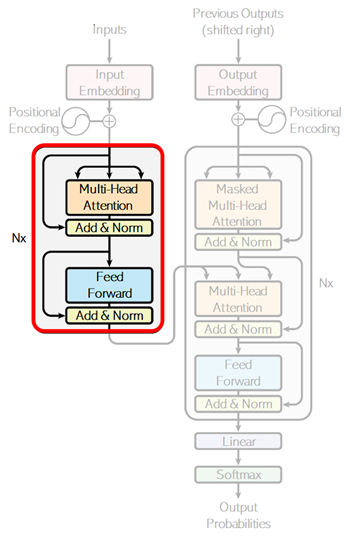

> Note : As we can see above, it adds an output of identity layer (which is written by "Add&Norm" in above picture) in the end of each layers. This is a known technique called **residual learning** in order to address a degradation problem of training accuracy in deep networks. (See "[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)" (He, et al., 2015) for details.)<br>
> 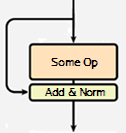 <br>
> Today, a lot of transformers place the layer normalization between the residual blocks as follows. (In this example, I'll create the code implementation accompanying the original paper.)<br>
> 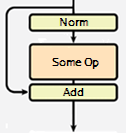

> Note : As we can see below, we have also added a dropout for regularization in the following code.<br>

In [43]:
class SingleEncodingLayer(nn.Module):
    def __init__(self, model_dim, num_heads, hidden_dim):
        super().__init__()

        self.self_attention = MyMultiHeadAttention(
            embedding_dim=model_dim,
            attention_dim=model_dim,
            num_heads=num_heads,
        )
        self.norm = nn.LayerNorm(model_dim, eps=0.001)
        self.output_dense1 = nn.Linear(model_dim, hidden_dim)
        self.output_dense2 = nn.Linear(hidden_dim, model_dim)

    def forward(self, inputs, masks):
        # apply self-attention
        attention_outputs = self.self_attention(inputs, masks)
        # add & layer norm (with dropout)
        attention_outputs = F.dropout(attention_outputs, p=0.1)
        attention_outputs = attention_outputs + inputs
        attention_outputs = self.norm(attention_outputs)
        # feed forward
        linear_outputs = self.output_dense1(attention_outputs)
        linear_outputs = F.relu(linear_outputs)
        linear_outputs = self.output_dense2(linear_outputs)
        # add & layer norm (with dropout)
        linear_outputs = F.dropout(linear_outputs, p=0.1)
        linear_outputs = linear_outputs + attention_outputs
        linear_outputs = self.norm(linear_outputs)

        return linear_outputs

With previously generated component (```SingleEncodingLayer```), now we implement the multi-layered encoder as follows.

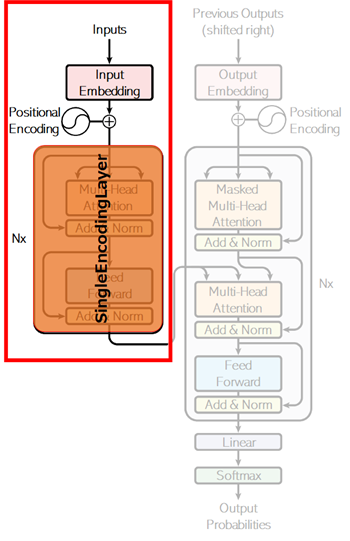

In [44]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, seq_len, padding_idx, model_dim, num_layers, num_heads, hidden_dim):
        super().__init__()

        self.num_layers = num_layers
        self.padding_idx = padding_idx

        self.embedding = nn.Embedding(
            vocab_size,
            model_dim,
            padding_idx=padding_idx,
        )
        self.pos_encoding = PositionalEncoding(
            seq_len=seq_len,
            embedding_dim=model_dim,
        )
        self.encoding_layers = nn.ModuleList([
            SingleEncodingLayer(
                model_dim=model_dim,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
            )
            for _ in range(num_layers)])

    def forward(self, inputs):
        # get mask
        masks = (inputs != self.padding_idx).int()
        # apply embedding
        outputs = self.embedding(inputs)
        # apply positional encoding
        outputs = self.pos_encoding(outputs)
        # apply multi-layered encoders
        for enc_layer in self.encoding_layers:
            outputs = enc_layer(outputs, masks)

        return outputs, masks

<hr>

<hr>

## Decoder

Next implement decoder side.<br>
Same as encoder, we'll first implement a repeatable single layer component as the following picture shows.

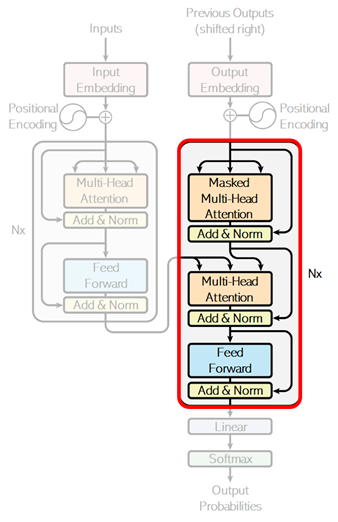

Unlike encoder, both self-attention and cross-attention are applied in decoder. (See above.)

In the first attention, the target sequence (English) is encoded by self-attention. As mentioned above, causal masking is applied in this decoder's self-attention. (Set the property ```use_causal_mask=True``` in our custom attention.)<br>

The next attention (cross-attention) is for machine translation. Same as Attention Model, both the encoder's outputs (contexts) for source (French) and the current decoded results for target (English) are fed into this attention, and the attended results between decoder's inputs and encoder's outputs will be obtained.

In [46]:
class SingleDecodingLayer(nn.Module):
    def __init__(self, model_dim, num_heads, hidden_dim):
        super().__init__()

        self.self_attention = MyMultiHeadAttention(
            embedding_dim=model_dim,
            attention_dim=model_dim,
            num_heads=num_heads,
            use_causal_mask=True,
        )
        self.cross_attention = MyMultiHeadAttention(
            embedding_dim=model_dim,
            attention_dim=model_dim,
            num_heads=num_heads,
        )
        self.norm = nn.LayerNorm(model_dim, eps=0.001)
        self.output_dense1 = nn.Linear(model_dim, hidden_dim)
        self.output_dense2 = nn.Linear(hidden_dim, model_dim)

    def forward(self, inputs, masks, enc_outputs, enc_masks):
        # self-attention with causal masking
        attention_outputs = self.self_attention(inputs, masks)
        # add & layer norm (with dropout)
        attention_outputs = F.dropout(attention_outputs, p=0.1)
        attention_outputs = attention_outputs + inputs
        attention_outputs = self.norm(attention_outputs)
        # encoder-decoder attention
        scored_outputs = self.cross_attention(
            input1=attention_outputs,
            mask1=masks,
            input2=enc_outputs,
            mask2=enc_masks,
        )
        # add & layer norm (with dropout)
        scored_outputs = F.dropout(scored_outputs, p=0.1)
        scored_outputs = scored_outputs + attention_outputs
        scored_outputs = self.norm(scored_outputs)
        # feed forward
        linear_outputs = self.output_dense1(scored_outputs)
        linear_outputs = F.relu(linear_outputs)
        linear_outputs = self.output_dense2(linear_outputs)
        # add & layer norm (with dropout)
        linear_outputs = F.dropout(linear_outputs, p=0.1)
        linear_outputs = linear_outputs + scored_outputs
        linear_outputs = self.norm(linear_outputs)

        return linear_outputs

Now we build multi-layered decoder with previous layer component (```SingleDecodingLayer```).

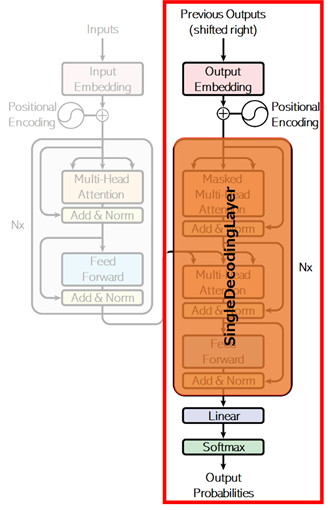

The outputs is used for predicting the next vocabulary by one-hot outputs, and the output's shape will then be ```(batch_size, sequence_length, vocabulary_size)```.

> Note : In this example, the final softmax will be applied in loss computation, and here we don't explicitly implement this operation in this module. (The decoder will then output logits, not probabilities.)

In [49]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, seq_len, padding_idx, model_dim, num_layers, num_heads, hidden_dim):
        super().__init__()

        self.num_layers = num_layers
        self.padding_idx = padding_idx

        self.embedding = nn.Embedding(
            vocab_size,
            model_dim,
            padding_idx=padding_idx,
        )
        self.pos_encoding = PositionalEncoding(
            seq_len=seq_len,
            embedding_dim=model_dim,
        )
        self.decoding_layers = nn.ModuleList([
            SingleDecodingLayer(
                model_dim=model_dim,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
            )
            for _ in range(num_layers)])
        self.output_dense = nn.Linear(model_dim, vocab_size)

    def forward(self, target_inputs, enc_outputs, enc_masks):
        # get mask
        target_masks = (target_inputs != self.padding_idx).int()
        # apply embedding
        outputs = self.embedding(target_inputs)
        # apply positional encoding
        outputs = self.pos_encoding(outputs)
        # apply multi-layered decoders
        for dec_layer in self.decoding_layers:
            outputs = dec_layer(
                inputs=outputs,
                masks=target_masks,
                enc_outputs=enc_outputs,
                enc_masks=enc_masks,
            )
        # apply final Linear
        #   (batch_size, seq_len, model_dim) --> (batch_size, seq_len, vocab_size)
        outputs = self.output_dense(outputs)

        return outputs

## Train Model (Transformer)

Using previous models, now we build the training loop.

First we set the following parameters for training.<br>
In this example, the training dataset consists of single sentences (not long text) and reduced parameters are used to speed up the training, compared with the parameters which is used in the original paper.

> Note : By increasing parameters, transformers will have the ability to capture more difficult contexts, but it'll need more training and corpus.

In [50]:
model_dim = 256
num_heads = 8
num_layers = 4
hidden_dim = 1024

### In the original paper, the following parameters are used. ###
#model_dim = 512
#num_heads = 8
#num_layers = 6
#hidden_dim = 2048

In the original paper, the following learning rate scheduler is used for this model, and we also apply this scheduling in this training.<br>
The following function is used to modify learning rate in the training.

$$ \verb|lrate| = d^{-0.5}_{\verb|model|} \cdot \min(\verb|step_num|^{-0.5},\verb|step_num|\cdot\verb|warmup_steps|^{-1.5}) $$

In [51]:
def get_lr(step, model_dim, warmup_steps=4000):
    step = float(step)
    model_dim = float(model_dim)
    if step == 0.0:
        val1 = 0.0
    else:
        val1 = 1.0 / (step ** 0.5)
    val2 = step / (warmup_steps ** 1.5)
    return min(val1,val2) / (model_dim ** 0.5)

Now, put it all together and run training as follows.

In below code, the loss on label id=-100 is ignored in ```cross_entropy()``` function. The padded position and the end of sequence will then be ignored in optimization.

> Note : Because the default value of  ```ignore_index``` property in ```cross_entropy()``` function is -100. (You can change this default value.)

Transformer has ability to capture complex contexts, but pls note that here we just simply apply training by using primitive data of single sentence in small epochs.<br>
Please try more large and complex data by adjusting above parameters and the number of training epochs.

We will also find that transformer is fast.

In [52]:
num_epochs = 1 #5

enc_model = Encoder(
    vocab_size=vocab_fr.__len__(),
    seq_len=seq_len_fr,
    padding_idx=pad_index_fr,
    model_dim=model_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
).to(device)
dec_model = Decoder(
    vocab_size=vocab_en.__len__(),
    seq_len=seq_len_en,
    padding_idx=pad_index_en,
    model_dim=model_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
).to(device)

all_params = list(enc_model.parameters()) + list(dec_model.parameters())
optimizer = torch.optim.Adam(
    params=all_params,
    lr=get_lr(0, model_dim),
    betas=(0.9, 0.98),
    eps=1e-9,
)

step = 0
for epoch in range(num_epochs):
    for labels, sources, targets in dataloader:
        # optimize
        optimizer.zero_grad()
        enc_outputs, enc_masks = enc_model(sources)
        logits = dec_model(targets, enc_outputs, enc_masks)
        loss = F.cross_entropy(logits.transpose(1,2), labels)
        loss.backward()
        # update learning rate and step
        lr = get_lr(step, model_dim)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        optimizer.step()
        step += 1
        # calculate accuracy
        pred_labels = logits.argmax(dim=2)
        num_correct = (pred_labels == labels).float().sum()
        num_total = (labels != -100).float().sum()
        accuracy = num_correct / num_total
        print("Epoch {} - loss: {:2.4f} - accuracy: {:2.4f}".format(epoch+1, loss.item(), accuracy), end="\r")
    print("")

Epoch 1 - loss: 1.6921 - accuracy: 0.6604


## Translate Text

Now translate French text to English text with trained model. (All these sentences are not in training set.)

Here we simply translate several brief sentences, but the metrics to evaluate text-generation task will not be so easy. (Because simply checking an exact match to a reference text is not optimal.)<br>
To eveluate the trained model, use some common metrics available in text generation, such as, BLEU or ROUGE.

> Note : Here we use greedy search and this will sometimes lead to wrong sequence. For drawbacks and solutinos.

In [54]:
import numpy as np

end_index_en = stoi_en["<end>"]
max_output = 128

def translate(sentence):
    # preprocess inputs
    text_fr = sentence
    text_fr = text_fr.lower()
    text_fr = " ".join(["<start>", text_fr, "<end>"])
    text_en_list = ["<start>"]
    text_en = " ".join(text_en_list)
    _, tokens_fr, tokens_en = collate_batch(list(zip([text_fr], [text_en])))

    # process encoder
    enc_outputs, enc_masks = enc_model(tokens_fr)

    # process decoder
    for loop in range(max_output):
        logits = dec_model(
            tokens_en,
            enc_outputs,
            enc_masks,
        )
        idx_en = logits[0][len(text_en_list) - 1].argmax()
        next_word_en = itos_en[idx_en]
        text_en_list.append(next_word_en)
        if idx_en.item() == end_index_en:
            break
        text_en = " ".join(text_en_list)
        _, _, tokens_en = collate_batch(list(zip([text_fr], [text_en])))

    return " ".join(text_en_list)

In [55]:
print(translate("j'aime la guitare")) # i like guitar
print(translate("il vit au japon")) # he lives in Japan
print(translate("ce stylo est utilisé par lui")) # this pen is used by him
print(translate("c'est ma chanson préférée")) # that's my favorite song
print(translate("il conduit une voiture et va à new york")) # he drives a car and goes to new york

<start> i like guitar <end>
<start> he lives at japan <end>
<start> this pen was a traffic <end>
<start> that's my favorite song <end>
<start> he drives a car and will be new new new new new york <end>
